In [2]:
import pandas as pd
import math
import pingouin as pg
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy as sp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.express as px
import plotly
import plotly.graph_objects as go
from plotly.graph_objs import Scatter, Figure, Histogram, Layout, Bar
plotly.offline.init_notebook_mode(connected = True)
from plotly.subplots import make_subplots

In [896]:
with open('data.csv') as x:
    ncols = len(x.readline().split(','))

df_raw = pd.read_csv('data.csv', usecols=range(1,ncols))

In [1623]:
df = df_raw.copy()

In [1625]:
df.head()

,Zone,State,City,Name,Type,Establishment Year,time needed to visit in hrs,Google review rating,Entrance Fee in INR,Airport with 50km Radius,Weekly Off,Significance,DSLR Allowed,Number of google review in lakhs,Best Time to visit
0,Northern,Delhi,Delhi,India Gate,War Memorial,1921,0.5,4.6,0,Yes,NaN,Historical,Yes,2.60,Evening
1,Northern,Delhi,Delhi,Humayun's Tomb,Tomb,1572,2.0,4.5,30,Yes,NaN,Historical,Yes,0.40,Afternoon
2,Northern,Delhi,Delhi,Akshardham Temple,Temple,2005,5.0,4.6,60,Yes,NaN,Religious,No,0.40,Afternoon
3,Northern,Delhi,Delhi,Waste to Wonder Park,Theme Park,2019,2.0,4.1,50,Yes,Monday,Environmental,Yes,0.27,Evening
4,Northern,Delhi,Delhi,Jantar Mantar,Observatory,1724,2.0,4.2,15,Yes,NaN,Scientific,Yes,0.31,Morning


In [5]:
# Dataset shape
print(df.shape)
 
rows, columns = df.shape
print(f"The dataset comprises {rows} properties described across {columns} attributes.")

(325, 15)
The dataset comprises 325 properties described across 15 attributes.


In [6]:
data_types = df.dtypes
 
# View a few datatypes from the dataset (first and last 5 features)
print(data_types)

Zone                                 object
State                                object
City                                 object
Name                                 object
Type                                 object
Establishment Year                   object
time needed to visit in hrs         float64
Google review rating                float64
Entrance Fee in INR                   int64
Airport with 50km Radius             object
Weekly Off                           object
Significance                         object
DSLR Allowed                         object
Number of google review in lakhs    float64
Best Time to visit                   object
dtype: object


In [7]:
# Tally the total by data type
type_counts = data_types.value_counts()
 
print(type_counts)

object     11
float64     3
int64       1
Name: count, dtype: int64


In [8]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

# Combining the counts and percentages into a DataFrame for better visualization
missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})

# Sorting the DataFrame by the percentage of missing values in descending order
missing_info = missing_info.sort_values(by='Percentage', ascending=False)

# Display columns with missing values
print(missing_info[missing_info['Missing Values'] > 0])

            Missing Values  Percentage
Weekly Off             293   90.153846


In [9]:
# Check the structure of the dataset
print("\nStructure of the dataset:")
print(df.info())


Structure of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Zone                              325 non-null    object 
 1   State                             325 non-null    object 
 2   City                              325 non-null    object 
 3   Name                              325 non-null    object 
 4   Type                              325 non-null    object 
 5   Establishment Year                325 non-null    object 
 6   time needed to visit in hrs       325 non-null    float64
 7   Google review rating              325 non-null    float64
 8   Entrance Fee in INR               325 non-null    int64  
 9   Airport with 50km Radius          325 non-null    object 
 10  Weekly Off                        32 non-null     object 
 11  Significance                      325 non-nu

In [1627]:
# Convert column names to lowercase
df.columns = df.columns.str.lower()

#rename columns to make them easier to work with
df = df.rename(columns = {'establishment year':'year', 'time needed to visit in hrs':'time', 'google review rating':'rating',
                         'entrance fee in inr':'fee', 'airport with 50km radius':'airport', 'weekly off':'off',
                         'dslr allowed':'camera', 'number of google review in lakhs':'reviews', 'best time to visit':'visit'})

# convert Binary columns to numerical
df['camera_num'] = df['camera'].astype('category').cat.codes

df['airport_num'] = df['airport'].astype('category').cat.codes

# Convert 'Establishment Year' to numeric based on conditions
df['year_num'] = df['year'].apply(
    lambda x: int(re.findall('[0-9-]+', x)[0]) if re.findall('[0-9-]+', x) != [] else np.nan).apply(
    lambda x: x * 100 if abs(x) < 100 else x)

# Clean visit column category types
df['visit'] = df['visit'].str.strip().replace('All','Anytime').astype('category')

In [1629]:
#Create column for ratio of fee to time ("Value")
df['cost_ratio'] = df['fee'] / df['time']

#Normalize ratings column
scaler = StandardScaler()
df['rating_norm'] = scaler.fit_transform(df[['rating']])

#log scale skewed variables
df['fee_log'] = np.log1p(df['fee'])

df['reviews_log'] = np.log1p(df['reviews'])

df['cost_ratio_log'] = np.log1p(df['cost_ratio'])

In [12]:
# Descriptive statistics for numerical columns
print(df.describe())

             time      rating          fee     reviews  camera_num  \
count  325.000000  325.000000   325.000000  325.000000  325.000000   
mean     1.807692    4.486154   115.809231    0.408438    0.815385   
std      0.971398    0.274580   530.859785    0.646668    0.388584   
min      0.500000    1.400000     0.000000    0.010000    0.000000   
25%      1.000000    4.400000     0.000000    0.059000    1.000000   
50%      1.500000    4.500000     0.000000    0.170000    1.000000   
75%      2.000000    4.600000    40.000000    0.500000    1.000000   
max      7.000000    4.900000  7500.000000    7.400000    1.000000   

       airport_num     year_num   cost_ratio   rating_norm     fee_log  \
count   325.000000   213.000000   325.000000  3.250000e+02  325.000000   
mean      0.698462  1583.042254    43.621720 -9.073084e-16    1.834637   
std       0.459634   689.989850   185.167754  1.001542e+00    2.291259   
min       0.000000 -3500.000000     0.000000 -1.125688e+01    0.000000   

Proceeding with univariate analysis

In [803]:
def univariate(x, df=df, outliers = 'yes'):
    display(df.sort_values(x, ascending = False).head())

    if df.sort_values(x, ascending = True).head()[x].sum() > 0:
        display(df.sort_values(x, ascending = True).head())

    if outliers == 'no':
        df = df.loc[df[[x]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
    
    fig = px.histogram(df, x=x, title = 'Histogram of ' + x, nbins = int(len(df) ** (1 / 2)), marginal = 'box', hover_name = 'name')
    fig.show()

,zone,state,city,name,type,year,time,rating,fee,airport,...,reviews,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,fee_log,reviews_log,cost_ratio_log
78,Western,Gujarat,Ahmedabad,Science City,Science,2002,7.0,4.4,500,Yes,...,0.11,Anytime,1,1,2002.0,71.428571,-0.314250,6.216606,0.104360,4.282601
200,Northern,Jammu and Kashmir,Anantnag,Amarnath Cave,Temple,Unknown,6.0,4.5,0,No,...,0.11,Anytime,1,0,NaN,0.000000,0.050504,0.000000,0.104360,0.000000
110,Southern,Kerala,Kochi,Wonderla Amusement Park,Amusement Park,2016,5.5,4.6,750,Yes,...,0.41,Anytime,1,1,2016.0,136.363636,0.415259,6.621406,0.343590,4.922632
15,Northern,Delhi,Delhi,National Science Centre,Science,1992,5.0,4.4,70,Yes,...,0.23,Anytime,1,1,1992.0,14.000000,-0.314250,4.262680,0.207014,2.708050
26,Western,Maharastra,Lonavala,Imagicaa,Amusement Park,2013,5.0,1.4,1149,No,...,0.95,Anytime,1,0,2013.0,229.800000,-11.256880,7.047517,0.667829,5.441552


,zone,state,city,name,type,year,time,rating,fee,airport,...,reviews,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,fee_log,reviews_log,cost_ratio_log
0,Northern,Delhi,Delhi,India Gate,War Memorial,1921,0.5,4.6,0,Yes,...,2.600,Evening,1,1,1921.0,0.0,0.415259,0.0,1.280934,0.0
220,Eastern,West Bengal,Bolpur,Kankalitala Temple,Temple,Unknown,0.5,4.7,0,Yes,...,0.045,Anytime,0,1,NaN,0.0,0.780013,0.0,0.044017,0.0
221,Eastern,West Bengal,Hooghly,Hangseswari Temple,Temple,1814,0.5,4.6,0,Yes,...,0.070,Anytime,0,1,1814.0,0.0,0.415259,0.0,0.067659,0.0
43,Eastern,West Bengal,Kolkata,Howrah Bridge,Bridge,1943,0.5,4.6,0,Yes,...,1.200,Anytime,0,1,1943.0,0.0,0.415259,0.0,0.788457,0.0
208,Northern,Ladakh,Leh,Magnetic Hill,Gravity Hill,Unknown,0.5,3.7,0,Yes,...,0.100,Anytime,1,1,NaN,0.0,-2.867530,0.0,0.095310,0.0


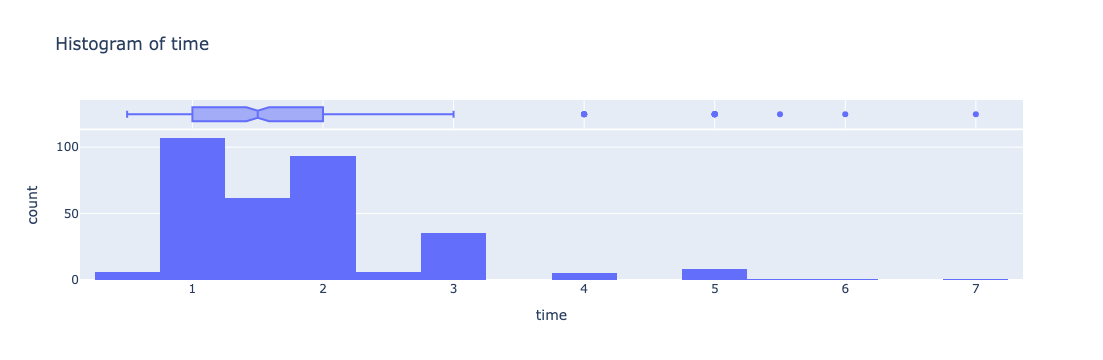

In [809]:
univariate('time', outliers = 'yes')

,zone,state,city,name,type,year,time,rating,fee,airport,...,reviews,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,fee_log,reviews_log,cost_ratio_log
196,Northern,Ladakh,Leh,Pangong Tso,Lake,Unknown,2.0,4.9,20,Yes,...,0.150,Morning,1,1,NaN,10.0,1.509522,3.044522,0.139762,2.397895
72,Western,Gujarat,Rann of Kutch,Rann Utsav,Cultural,Unknown,3.0,4.9,7500,Yes,...,0.100,Evening,1,1,NaN,2500.0,1.509522,8.922792,0.095310,7.824446
92,Northern,Punjab,Amritsar,Golden Temple (Harmandir Sahib),Religious Site,1604,1.5,4.9,0,Yes,...,1.900,Anytime,1,1,1604.0,0.0,1.509522,0.000000,1.064711,0.000000
94,Northern,Punjab,Amritsar,Wagah Border,Border Crossing,1950,2.0,4.8,0,Yes,...,0.170,Evening,1,1,1950.0,0.0,1.144767,0.000000,0.157004,0.000000
207,Northern,Ladakh,Dras,Dras War Memorial,War Memorial,Unknown,1.0,4.8,0,No,...,0.012,Anytime,1,0,NaN,0.0,1.144767,0.000000,0.011929,0.000000


,zone,state,city,name,type,year,time,rating,fee,airport,...,reviews,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,fee_log,reviews_log,cost_ratio_log
26,Western,Maharastra,Lonavala,Imagicaa,Amusement Park,2013,5.0,1.4,1149,No,...,0.95,Anytime,1,0,2013.0,229.8,-11.256880,7.047517,0.667829,5.441552
208,Northern,Ladakh,Leh,Magnetic Hill,Gravity Hill,Unknown,0.5,3.7,0,Yes,...,0.10,Anytime,1,1,NaN,0.0,-2.867530,0.000000,0.095310,0.000000
103,Southern,Kerala,Kumarakom,Kumarakom Bird Sanctuary,Bird Sanctuary,1972,2.0,3.8,50,Yes,...,0.10,Anytime,1,1,1972.0,25.0,-2.502776,3.931826,0.095310,3.258097
264,Southern,Andhra Pradesh,Visakhapatnam,Matsyadarshini Aquarium,Aquarium,Unknown,1.0,3.8,20,Yes,...,0.03,Anytime,1,1,NaN,20.0,-2.502776,3.044522,0.029559,3.044522
167,Northern,Himachal Pradesh,Kufri,Kufri Fun World,Ski Resort,1975,5.0,3.8,1500,Yes,...,0.10,Anytime,1,1,1975.0,300.0,-2.502776,7.313887,0.095310,5.707110


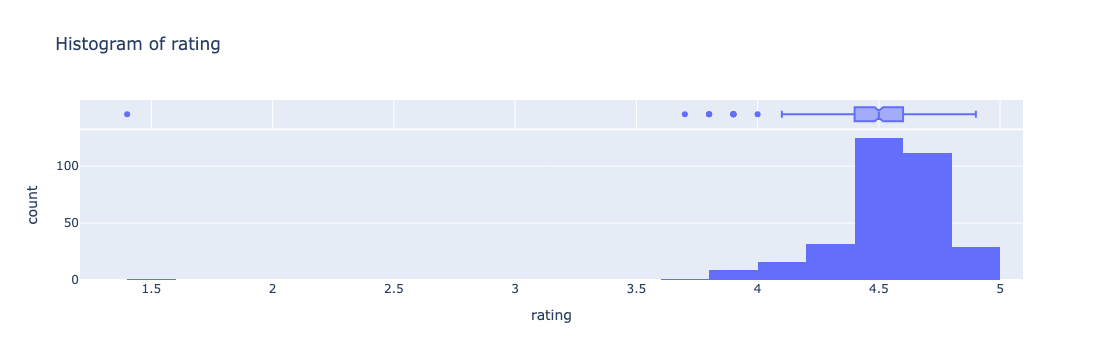

In [815]:
univariate('rating', outliers = 'yes')

,zone,state,city,name,type,year,time,rating,fee,airport,...,reviews,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,fee_log,reviews_log,cost_ratio_log
72,Western,Gujarat,Rann of Kutch,Rann Utsav,Cultural,Unknown,3.0,4.9,7500,Yes,...,0.10,Evening,1,1,NaN,2500.000000,1.509522,8.922792,0.095310,7.824446
68,Western,Gujarat,Junagadh,Gir National Park,National Park,1965,3.0,4.5,3500,No,...,0.08,Morning,1,0,1965.0,1166.666667,0.050504,8.160804,0.076961,7.062763
161,Northern,Himachal Pradesh,Bir Billing,Paragliding Site,Adventure Sport,2005,2.0,4.8,2500,No,...,0.01,Anytime,1,0,2005.0,1250.000000,1.144767,7.824446,0.009950,7.131699
47,Eastern,West Bengal,Kolkata,Eden Gardens,Cricket Ground,1864,3.0,4.1,2500,Yes,...,0.10,Anytime,1,1,1864.0,833.333333,-1.408513,7.824446,0.095310,6.726633
315,Central,Uttar Pradesh,Greater Noida,Buddh International Circuit,Race Track,2011,2.0,4.6,1500,Yes,...,7.40,Anytime,1,1,2011.0,750.000000,0.415259,7.313887,2.128232,6.621406


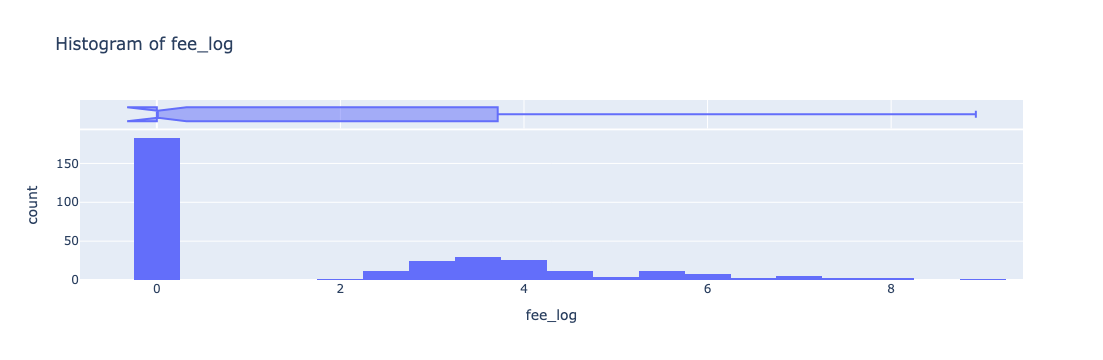

In [819]:
univariate('fee_log', outliers = 'yes')

,zone,state,city,name,type,year,time,rating,fee,airport,...,reviews,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,fee_log,reviews_log,cost_ratio_log
315,Central,Uttar Pradesh,Greater Noida,Buddh International Circuit,Race Track,2011,2.0,4.6,1500,Yes,...,7.40,Anytime,1,1,2011.0,750.0,0.415259,7.313887,2.128232,6.621406
17,Western,Maharastra,Mumbai,Gateway of India,Monument,1924,1.0,4.6,0,Yes,...,3.60,Anytime,1,1,1924.0,0.0,0.415259,0.000000,1.526056,0.000000
0,Northern,Delhi,Delhi,India Gate,War Memorial,1921,0.5,4.6,0,Yes,...,2.60,Evening,1,1,1921.0,0.0,0.415259,0.000000,1.280934,0.000000
111,Southern,Karnataka,Mysore,Mysore Palace,Palace,1912,2.0,4.6,50,Yes,...,2.50,Anytime,1,1,1912.0,25.0,0.415259,3.931826,1.252763,3.258097
181,Central,Uttar Pradesh,Agra,Taj Mahal,Mausoleum,1632,2.0,4.6,50,Yes,...,2.25,Morning,1,1,1632.0,25.0,0.415259,3.931826,1.178655,3.258097


,zone,state,city,name,type,year,time,rating,fee,airport,...,reviews,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,fee_log,reviews_log,cost_ratio_log
175,Northern,Uttarakhand,Almora,Binsar Wildlife Sanctuary,Wildlife Sanctuary,1988,2.0,4.3,150,No,...,0.01,Anytime,1,0,1988.0,75.000000,-0.679004,5.017280,0.00995,4.330733
173,Northern,Uttarakhand,Auli,Auli Ski Resort,Ski Resort,1990,3.0,4.5,0,No,...,0.01,Morning,1,0,1990.0,0.000000,0.050504,0.000000,0.00995,0.000000
171,Northern,Uttarakhand,Dehradun,Robber's Cave,Cave,Unknown,1.5,4.5,25,Yes,...,0.01,Morning,1,1,NaN,16.666667,0.050504,3.258097,0.00995,2.871680
205,Northern,Jammu and Kashmir,Kishtwar,Kishtwar National Park,National Park,1981,3.0,4.3,100,No,...,0.01,Anytime,1,0,1981.0,33.333333,-0.679004,4.615121,0.00995,3.536117
238,Southern,Tamil Nadu,Rameswaram,Ramanathaswamy Temple,Temple,12th century,1.5,4.6,0,No,...,0.01,Anytime,0,0,1200.0,0.000000,0.415259,0.000000,0.00995,0.000000


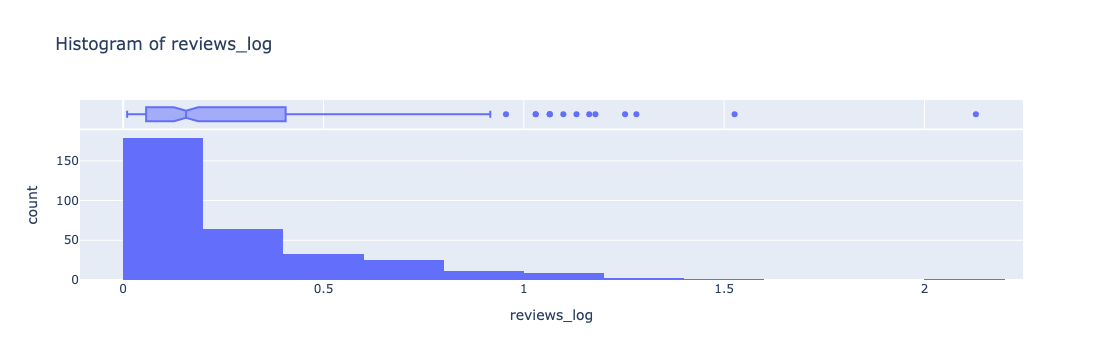

In [862]:
univariate('reviews_log', outliers = 'yes')

,zone,state,city,name,type,year,time,rating,fee,airport,...,reviews,visit,camera_num,airport_num,year_num,cost_ratio,rating_norm,fee_log,reviews_log,cost_ratio_log
72,Western,Gujarat,Rann of Kutch,Rann Utsav,Cultural,Unknown,3.0,4.9,7500,Yes,...,0.10,Evening,1,1,NaN,2500.000000,1.509522,8.922792,0.095310,7.824446
161,Northern,Himachal Pradesh,Bir Billing,Paragliding Site,Adventure Sport,2005,2.0,4.8,2500,No,...,0.01,Anytime,1,0,2005.0,1250.000000,1.144767,7.824446,0.009950,7.131699
68,Western,Gujarat,Junagadh,Gir National Park,National Park,1965,3.0,4.5,3500,No,...,0.08,Morning,1,0,1965.0,1166.666667,0.050504,8.160804,0.076961,7.062763
47,Eastern,West Bengal,Kolkata,Eden Gardens,Cricket Ground,1864,3.0,4.1,2500,Yes,...,0.10,Anytime,1,1,1864.0,833.333333,-1.408513,7.824446,0.095310,6.726633
315,Central,Uttar Pradesh,Greater Noida,Buddh International Circuit,Race Track,2011,2.0,4.6,1500,Yes,...,7.40,Anytime,1,1,2011.0,750.000000,0.415259,7.313887,2.128232,6.621406


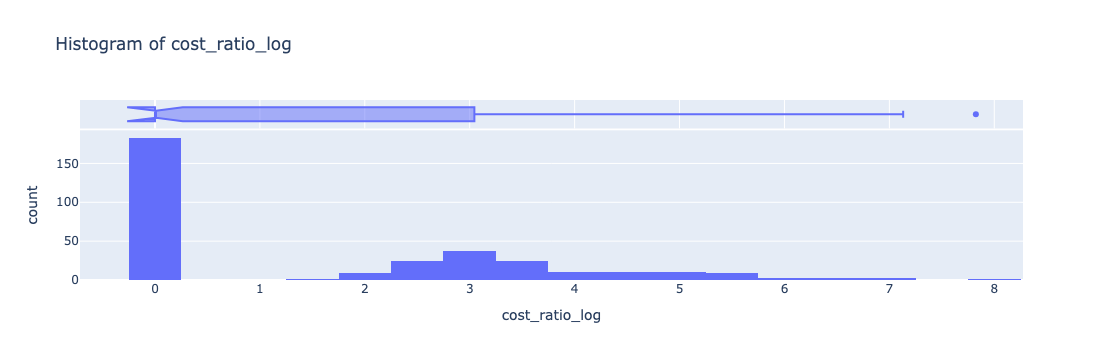

In [823]:
univariate('cost_ratio_log', outliers = 'yes')

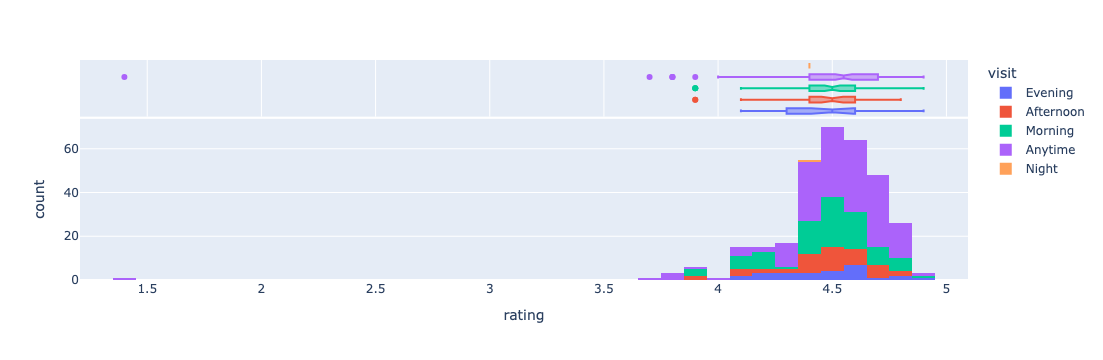

In [839]:
x = 'rating'

px.histogram(df, x=x, marginal = 'box', color = 'visit')

In [1696]:
def corr_matrix(x = None, y = None, df=df):
    if x == None:
        df = df
    else:
        df = df[df[x] == y]

    
    plt.figure(figsize=(8,6))
    corr_matrix = df.corr(numeric_only = True)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

def corr_table(x = None, y = None, df=df, t = 0.3):

    if x == None:
        df = df
    else:
        df = df[df[x] == y]

    
    corr = df.corr(numeric_only = True)

    result = []
    for row in corr.index:
        for col in corr:
            if row != col:
                result.append([row, col, corr[col][row]])
    
    
    corr_df = pd.DataFrame(result, columns = ['var_1','var_2','corr'])
    
    corr_df = corr_df.sort_values('corr', ascending = False)
    
    corr_df = corr_df[~(corr_df['var_1'].str.contains('rating') & corr_df['var_2'].str.contains('rating'))]
    
    corr_df = corr_df[~(corr_df['var_1'].str.contains('cost|fee') & corr_df['var_2'].str.contains('cost|fee'))]
    
    corr_df = corr_df[~(corr_df['var_1'].str.contains('reviews') & corr_df['var_2'].str.contains('reviews'))]
    
    corr_df = corr_df.iloc[::2]

    corr_df = corr_df[abs(corr_df['corr']) > t]

    corr_df['category'] = x
    corr_df['type'] = y

    return corr_df


def corr_info(x = None, y = None, df = df, t = 0.3):
    
    corr_matrix(x, y, df)

    display(corr_table(x, y, df, t))

def corr_cat(x, t=0.3, df=df, f = 3):
    corr_cat_df = pd.DataFrame()

    df = df.groupby(x, observed = False).filter(lambda x: len(x) > f)

    for y in df[x].unique():
        temp_df = corr_table(x, y, t=t)
        corr_cat_df = pd.concat([corr_cat_df, temp_df], axis = 0)

    return corr_cat_df

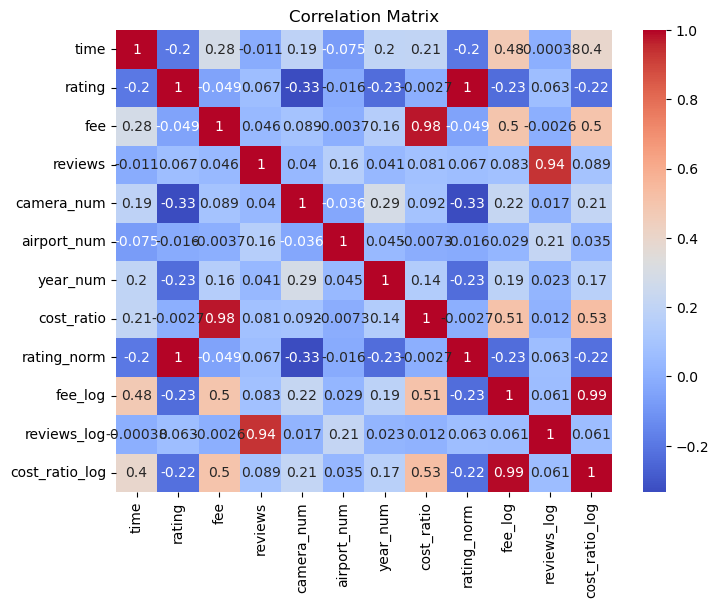

,var_1,var_2,corr,category,type
99,fee_log,time,0.475350,None,None
121,cost_ratio_log,time,0.395343,None,None
92,rating_norm,camera_num,-0.333549,None,None
14,rating,camera_num,-0.333549,None,None


In [1562]:
corr_info()

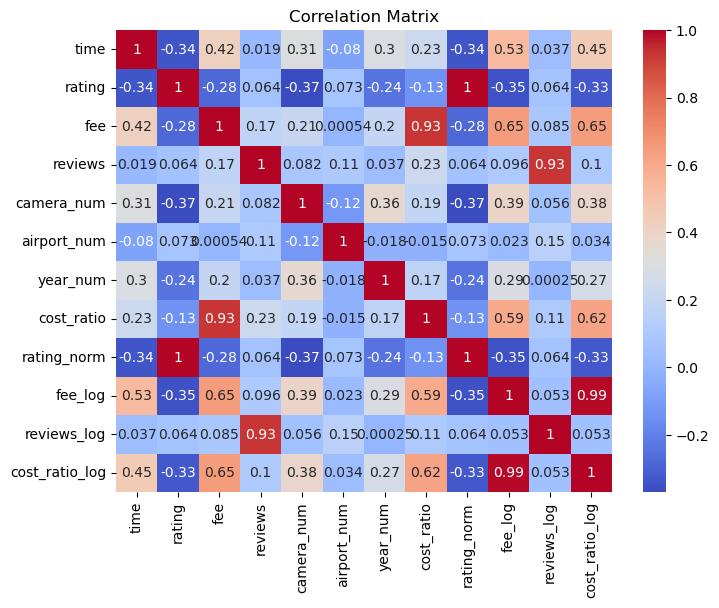

,var_1,var_2,corr,category,type
8,time,fee_log,0.532266,visit,Anytime
121,cost_ratio_log,time,0.452179,visit,Anytime
22,fee,time,0.417292,visit,Anytime
52,camera_num,fee_log,0.392050,visit,Anytime
125,cost_ratio_log,camera_num,0.381156,visit,Anytime
49,camera_num,year_num,0.361888,visit,Anytime
44,camera_num,time,0.308565,visit,Anytime
122,cost_ratio_log,rating,-0.330195,visit,Anytime
98,rating_norm,cost_ratio_log,-0.330195,visit,Anytime
0,time,rating,-0.342469,visit,Anytime


In [1744]:
corr_info('visit', 'Anytime')

In [1738]:
t = 0.9
f = 10
corr_total_df = pd.DataFrame()

for x in df.loc[:, df.columns != 'year'].select_dtypes(exclude='number').columns:
    temp_df = corr_cat(x, t=t, f = f)
    corr_total_df = pd.concat([corr_total_df, temp_df], axis = 0)

corr_total_df = corr_total_df.sort_values('corr', ascending = False)

In [1742]:
corr_total_df

,var_1,var_2,corr,category,type
74,year_num,fee_log,0.996861,state,Goa
74,year_num,fee_log,0.996861,city,Goa
83,cost_ratio,year_num,0.996861,state,Goa
72,year_num,cost_ratio,0.996861,state,Goa
72,year_num,cost_ratio,0.996861,city,Goa
83,cost_ratio,year_num,0.996861,city,Goa
68,year_num,fee,0.996861,city,Goa
68,year_num,fee,0.996861,state,Goa
60,airport_num,year_num,0.972135,visit,Evening
70,year_num,camera_num,0.972135,visit,Evening


In [1362]:
def bivar_box(x, y, df, text, cat):
    #filter outliers
    temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
    fig = px.box(temp_df, x=x, y=y, hover_name=text, color = cat, title = y + " vs " + x)

    return fig

def outliers(x, y, df=df):
    outliers_df = df[[x, y]].dropna()
    outliers_df = outliers_df.loc[~outliers_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
    outliers_df = outliers_df.merge(df, how = 'left', left_index = True, right_index = True, 
                              suffixes = ['', '_y'])[['name', x, y]].sort_values(by = y)

    return outliers_df

def bivar_sca(x, y, df=df, text = 'name', cat = None):
    #filter outliers
    temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
    fig = px.scatter(temp_df, x=x, y=y, color = cat, hover_name=text, title = y + " vs " + x)

    return fig


def bivariate(x, y, df=df, text = 'name', cat = None, type = 'sca'):

    if type == 'sca':
        bivar_sca(x, y, df, text, cat).show()
    elif type == 'box':
        bivar_box(x, y, df, text, cat).show()

    return display(outliers(x, y))
    


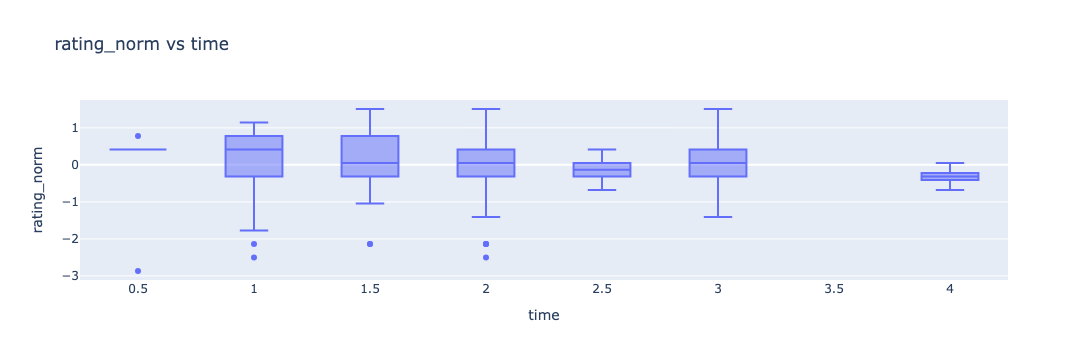

,name,time,rating_norm
26,Imagicaa,5.0,-11.256880
167,Kufri Fun World,5.0,-2.502776
24,Essel World,5.0,-0.679004
15,National Science Centre,5.0,-0.314250
78,Science City,7.0,-0.314250
200,Amarnath Cave,6.0,0.050504
110,Wonderla Amusement Park,5.5,0.415259
2,Akshardham Temple,5.0,0.415259
198,Vaishno Devi,5.0,0.780013
180,Valley of Flowers,5.0,0.780013


In [1364]:
bivariate('time','rating_norm', type='box')

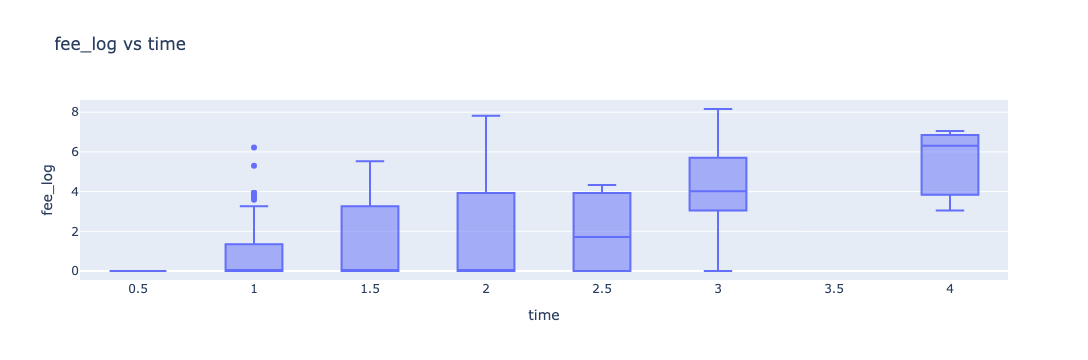

,name,time,fee_log
162,Triund Trek,5.0,0.000000
200,Amarnath Cave,6.0,0.000000
198,Vaishno Devi,5.0,0.000000
2,Akshardham Temple,5.0,4.110874
15,National Science Centre,5.0,4.262680
180,Valley of Flowers,5.0,5.017280
78,Science City,7.0,6.216606
110,Wonderla Amusement Park,5.5,6.621406
24,Essel World,5.0,7.047517
26,Imagicaa,5.0,7.047517


In [1366]:
bivariate('time', 'fee_log', type='box')

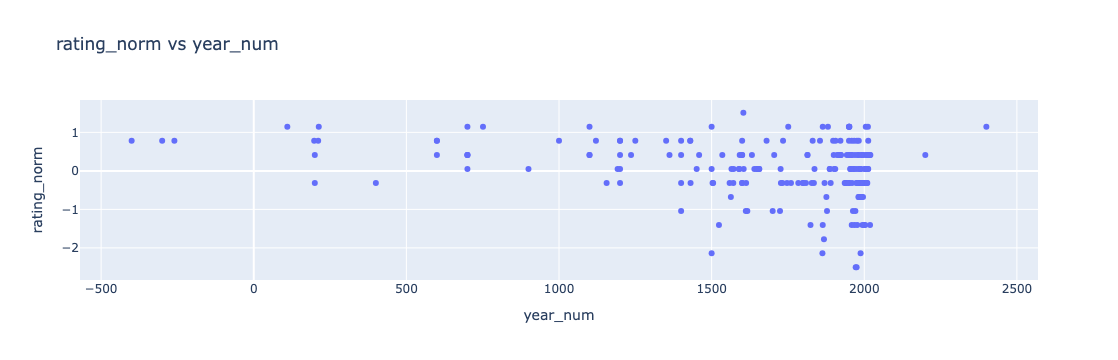

,name,year_num,rating_norm
26,Imagicaa,2013.0,-11.256880
229,Barabati Fort,-987.0,0.050504
189,Dhamek Stupa,-500.0,0.415259
136,Khajuraho Group of Monuments,-850.0,0.780013
174,Badrinath Temple,-820.0,1.144767
140,Mahakaleshwar Jyotirlinga,-3500.0,1.144767


In [1748]:
bivariate('year_num', 'rating_norm')

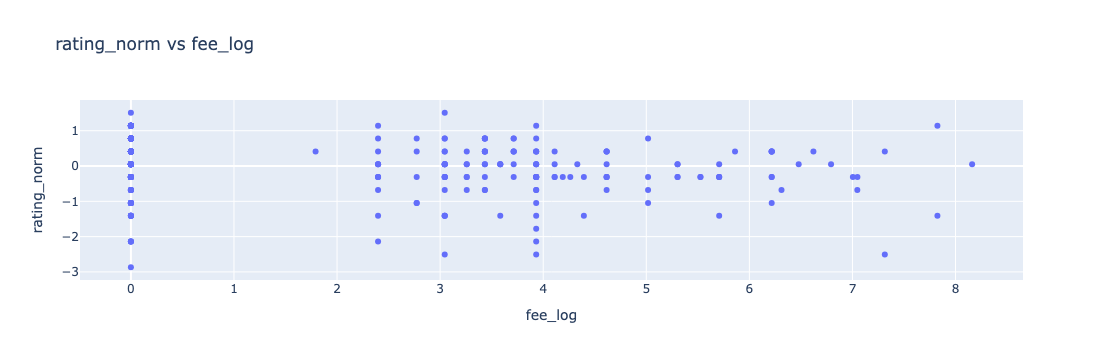

,name,fee_log,rating_norm
26,Imagicaa,7.047517,-11.256880
72,Rann Utsav,8.922792,1.509522


In [1734]:
bivariate('fee_log','rating_norm')

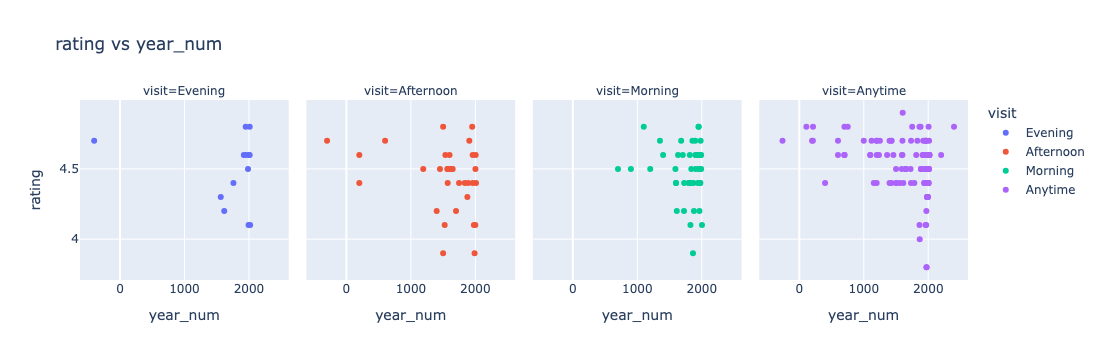

In [1804]:
x = 'year_num'
y = 'rating'
text = 'name'
cat = 'visit'

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
fig = px.scatter(temp_df, x=x, y=y, color = cat, hover_name=text, title = y + " vs " + x, facet_col = 'visit', facet_col_wrap=10)

fig.show()

In [1752]:
corr_total_df

,var_1,var_2,corr,category,type
74,year_num,fee_log,0.996861,state,Goa
74,year_num,fee_log,0.996861,city,Goa
83,cost_ratio,year_num,0.996861,state,Goa
72,year_num,cost_ratio,0.996861,state,Goa
72,year_num,cost_ratio,0.996861,city,Goa
83,cost_ratio,year_num,0.996861,city,Goa
68,year_num,fee,0.996861,city,Goa
68,year_num,fee,0.996861,state,Goa
60,airport_num,year_num,0.972135,visit,Evening
70,year_num,camera_num,0.972135,visit,Evening


state
Goa
0


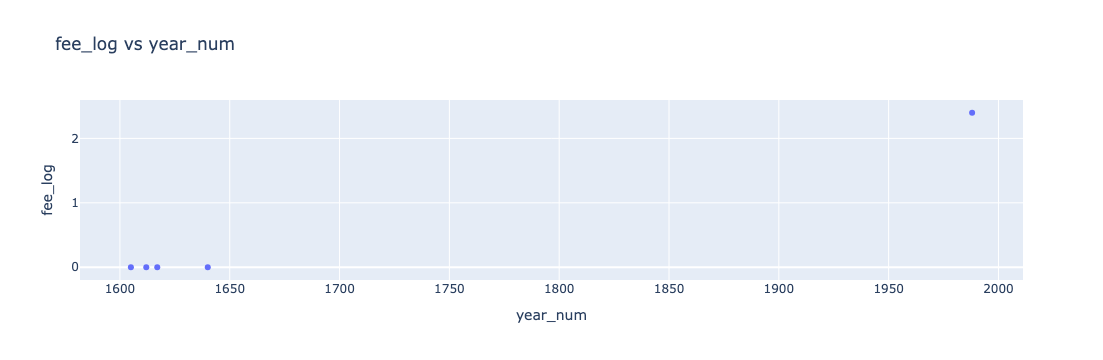

city
Goa
1


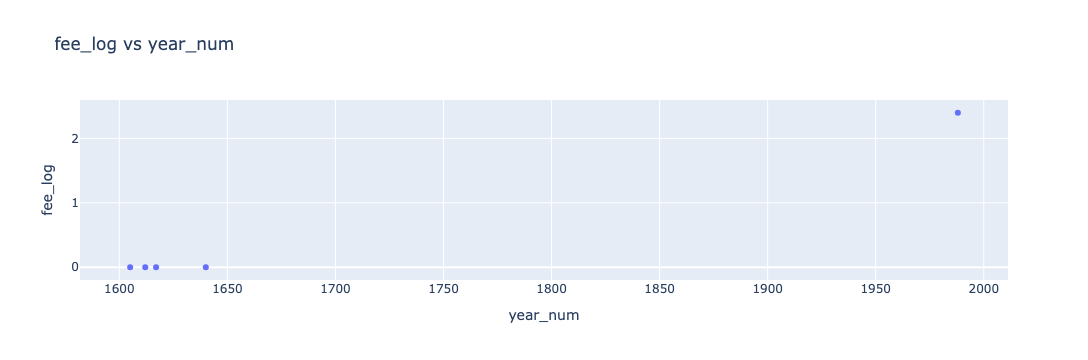

state
Goa
2


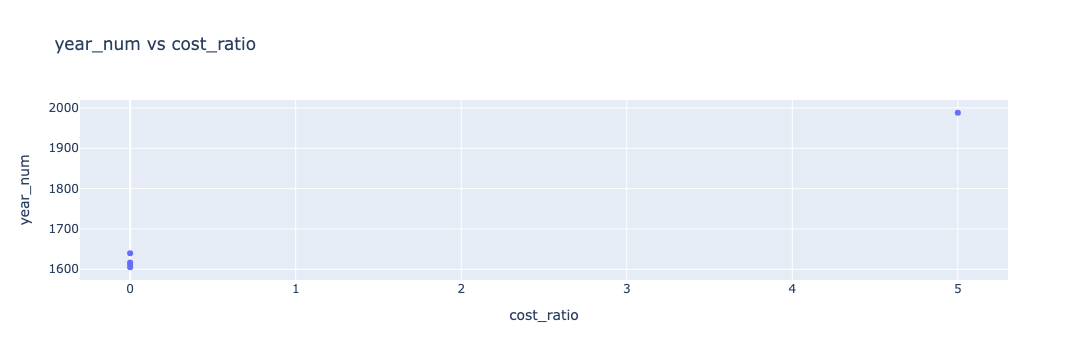

state
Goa
3


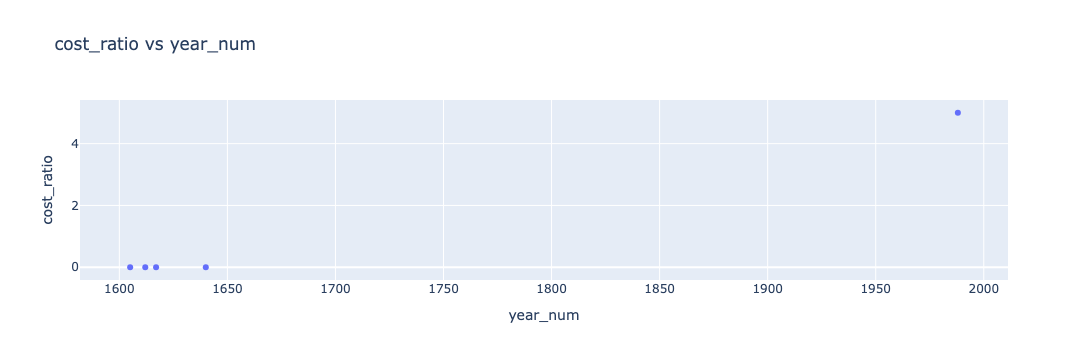

city
Goa
4


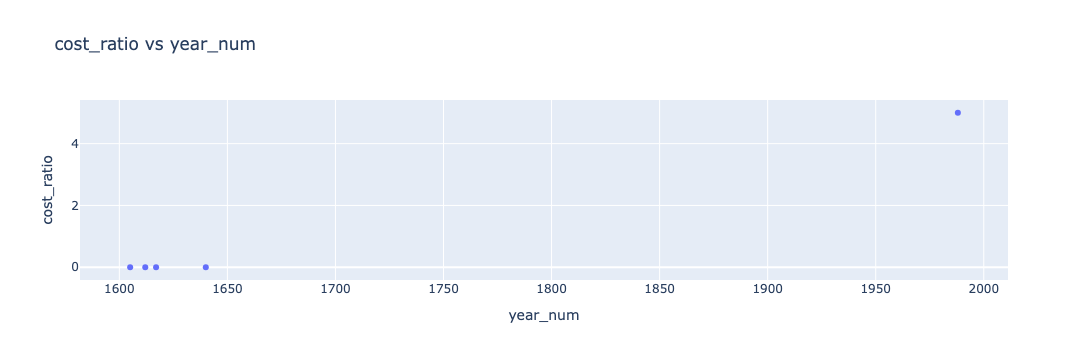

city
Goa
5


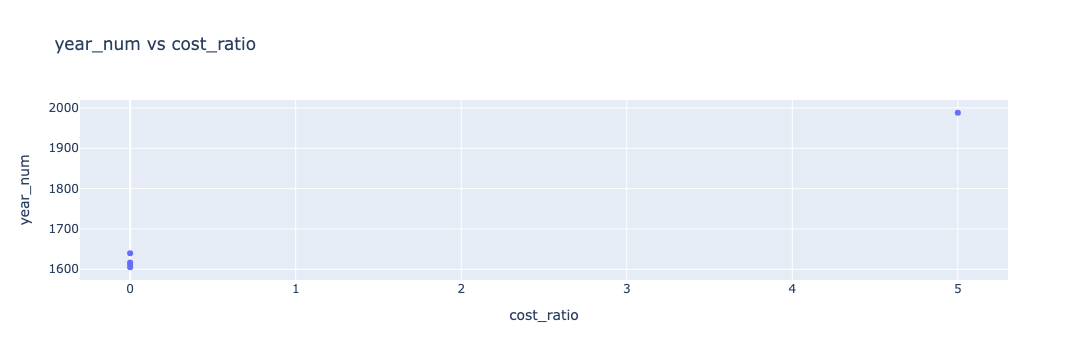

city
Goa
6


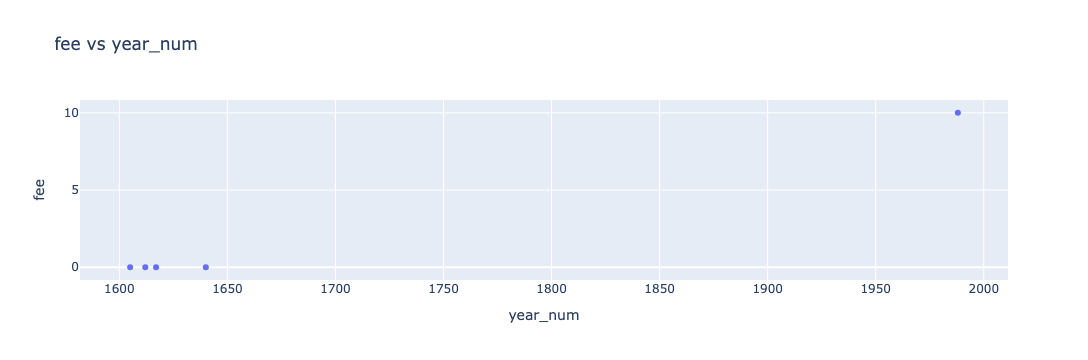

state
Goa
7


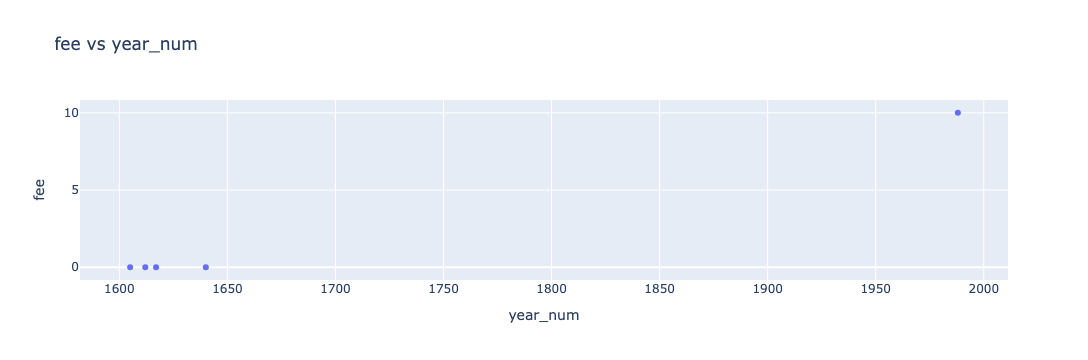

visit
Evening
8


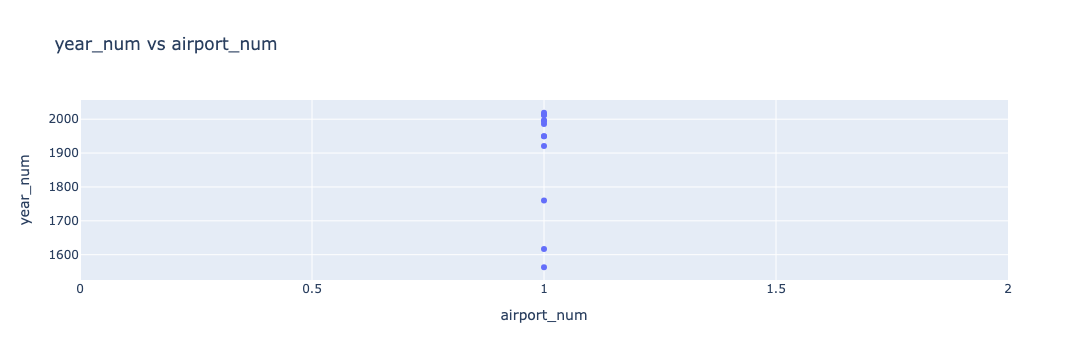

visit
Evening
9


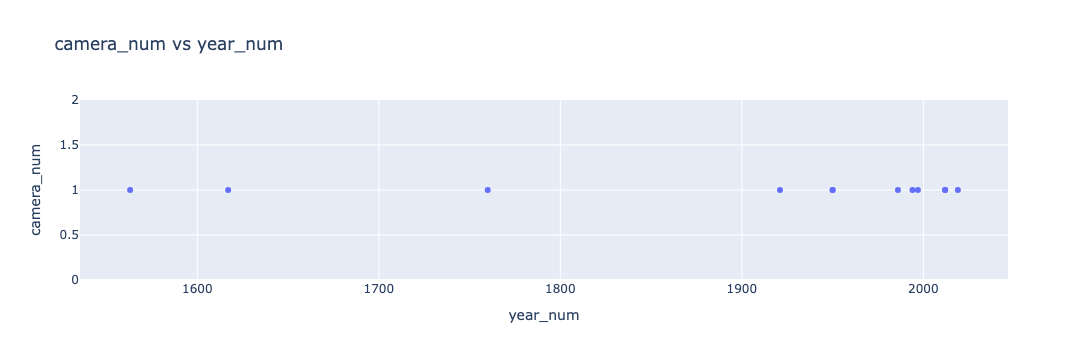

state
Uttar Pradesh
10


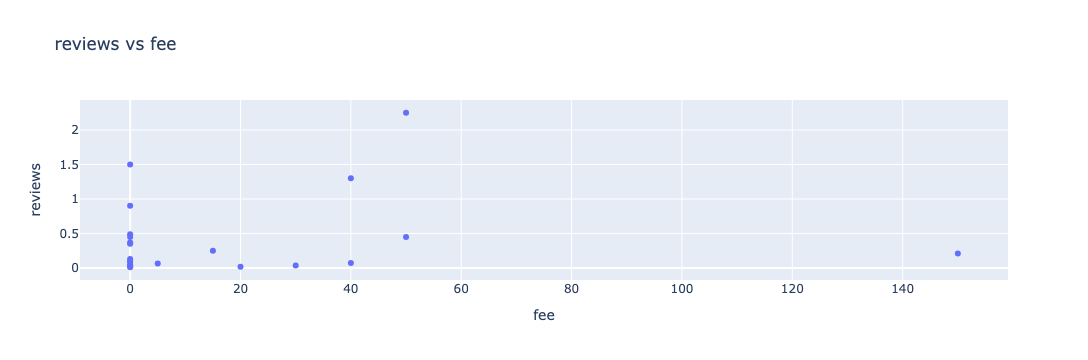

state
Uttar Pradesh
11


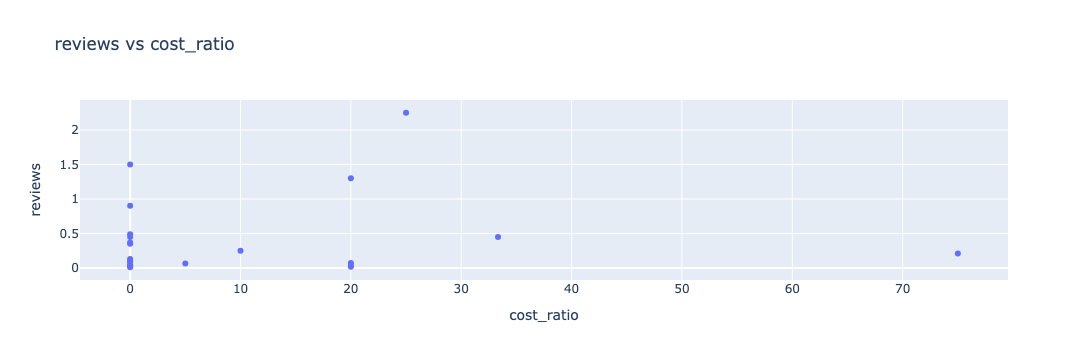

type
Waterfall
12


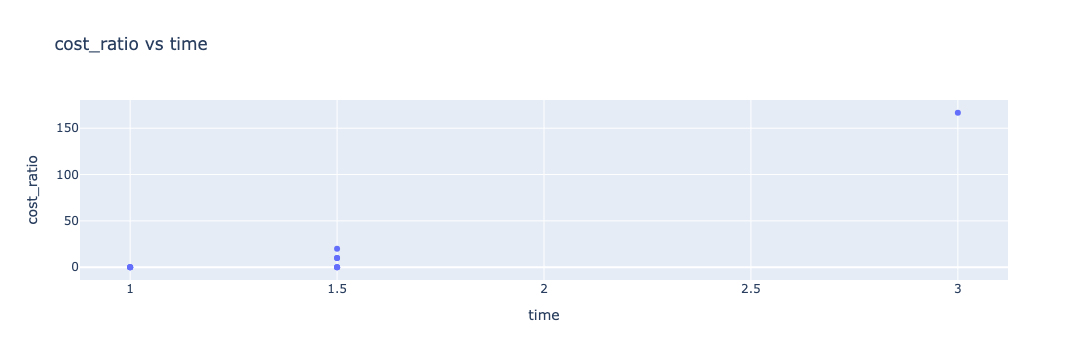

type
Waterfall
13


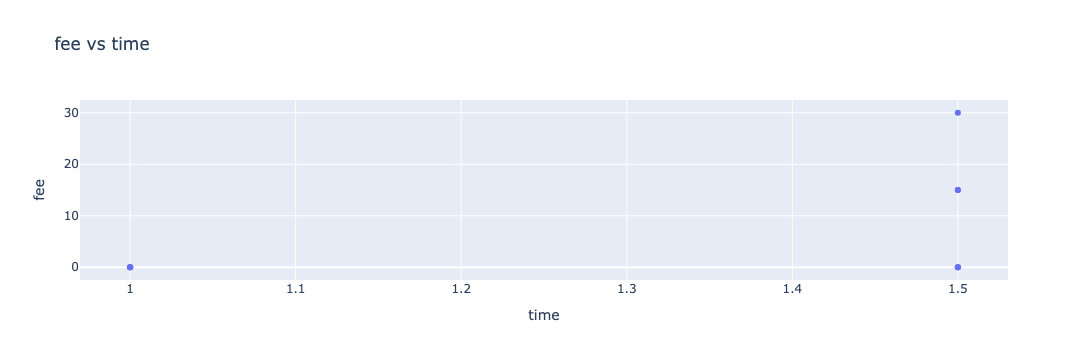

zone
Central
14


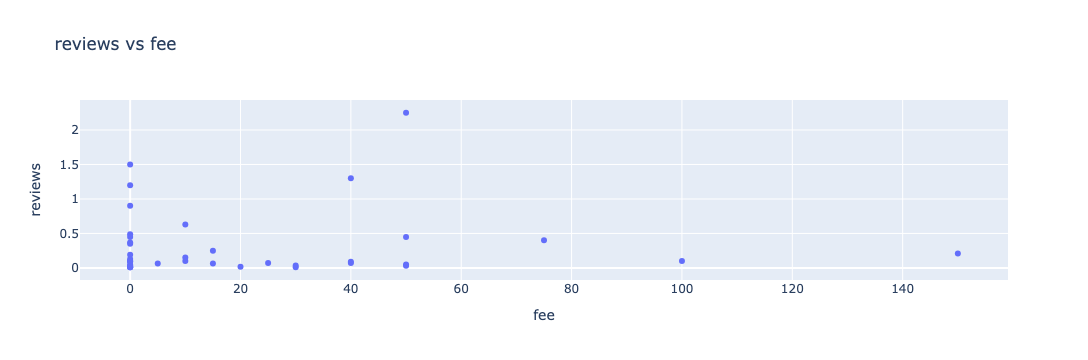

zone
Central
15


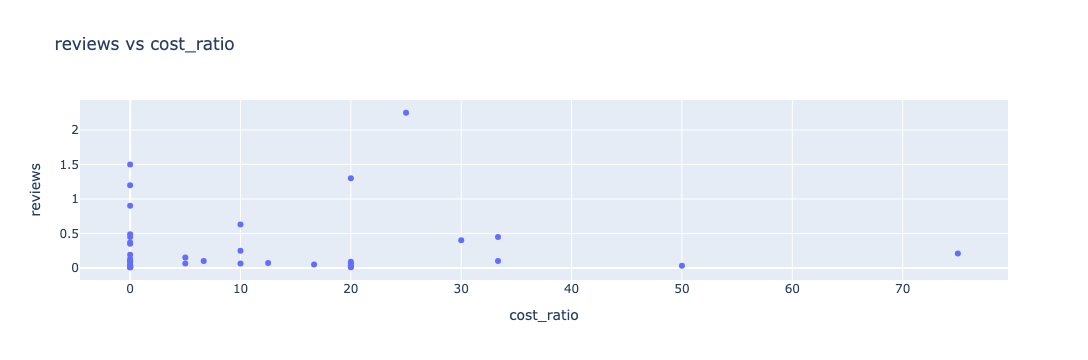

state
Tamil Nadu
16


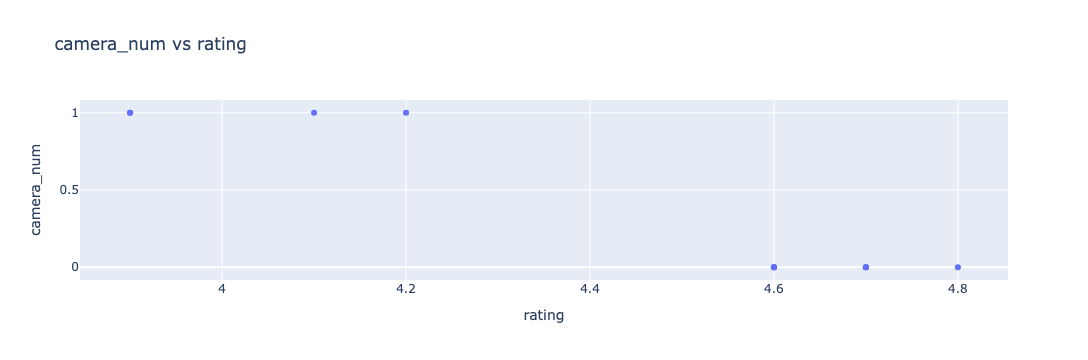

state
Tamil Nadu
17


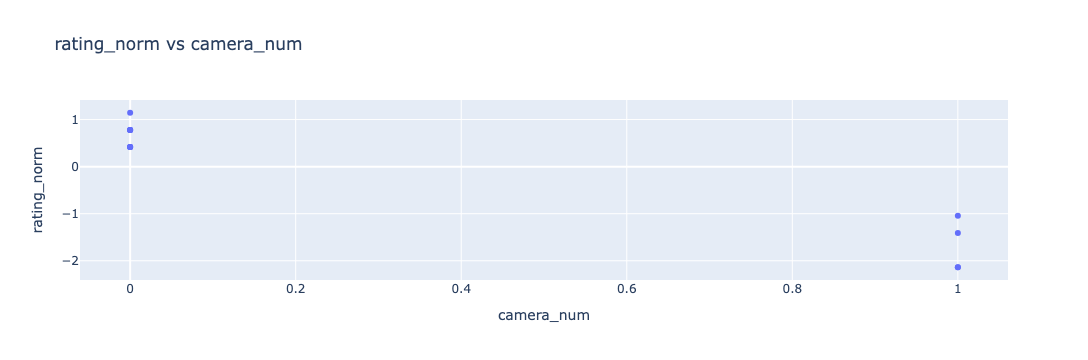

type
Lake
18


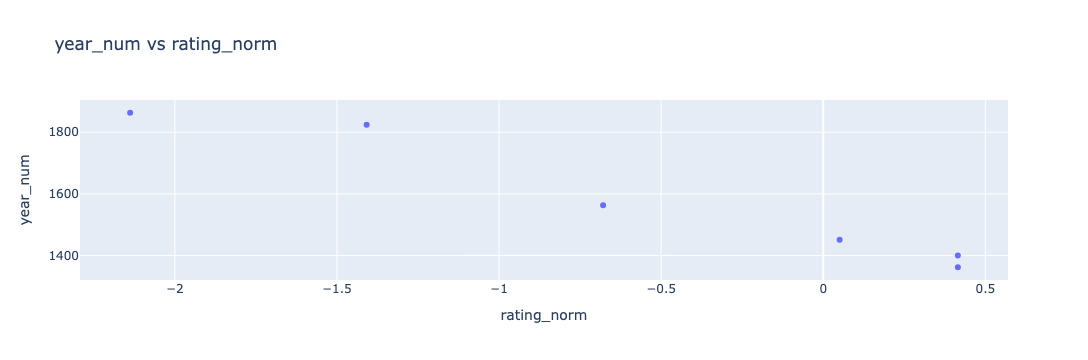

type
Lake
19


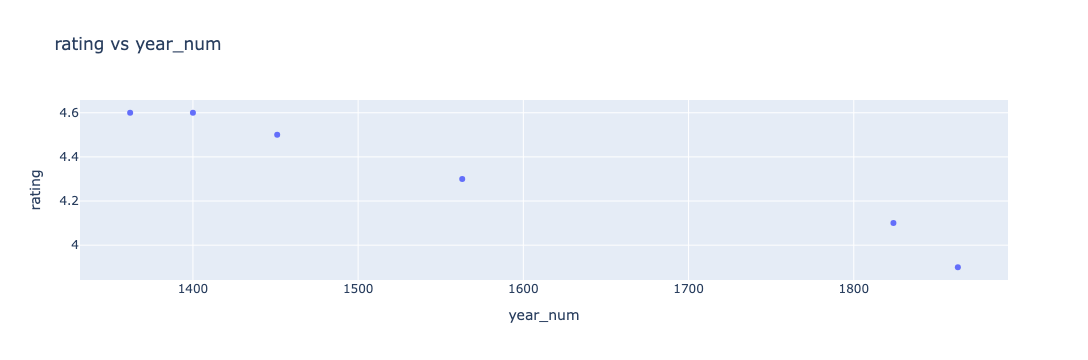

In [1948]:
loc = 0

for loc in range(0, len(corr_total_df)):
    var_1, var_2, corr, category, type = corr_total_df.iloc[loc]
    print(category)
    print(type)
    print(loc)
    display(bivar_sca(var_1, var_2, df = df[df[category] == type]))
    loc += 1

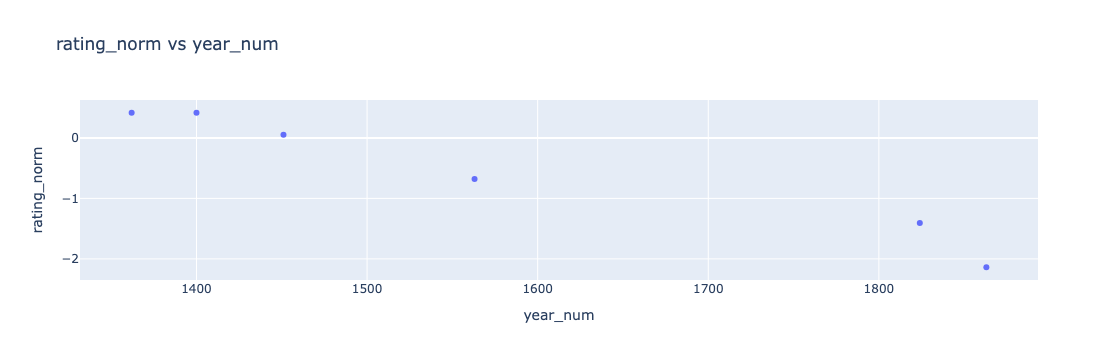

In [1750]:
bivar_sca('year_num', 'rating_norm', df = df[df['type'] == 'Lake'])

In [ ]:
#categorical analysis

In [677]:
def cat_hist(x, y, df=df):
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)
    fig = px.histogram(temp_df, x=x).update_xaxes(categoryorder="total descending")

    return fig


def cat_bar(x, y, df=df):
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    x, observed = False)[[y]].mean().sort_values(y, ascending = False).dropna()

    fig = px.bar(temp_df, y=y)

    fig.update_layout(
        title="Average rating for each "+ x + " category",
        xaxis_title="",
        yaxis_title=y,)

    return fig

def cat_ttest(x, y, df=df):
    cat_lst = []
    p_lst = []
  
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    x, observed = False)[[y]].mean().sort_values(y, ascending = False).dropna()

    for category in temp_df.index:
        p = sp.stats.ttest_1samp(df[df[x] == category][y], df[y].mean())[1]
        if p < 0.05:
            cat_lst.append(category)
            p_lst.append(p)

        
    p_df = pd.DataFrame(list(zip(cat_lst, p_lst)), columns = ['category', 'p-value'])

    if p_df.empty:
        pass
    else:
        return p_df
        


def categorical(x, y, df=df):

    cat_hist(x, y).show()
    
    cat_bar(x, y).show()
    
    print(pg.anova(data=df, dv=y, between=x))
    
    temp_df = cat_ttest(x, y, df=df)
    
    
    return temp_df
    
    #temp_fig_1, temp_fig_2, s, temp_df

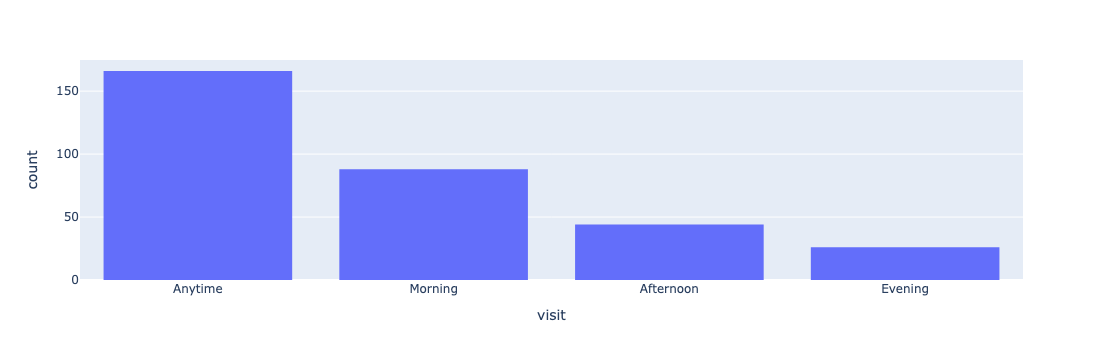

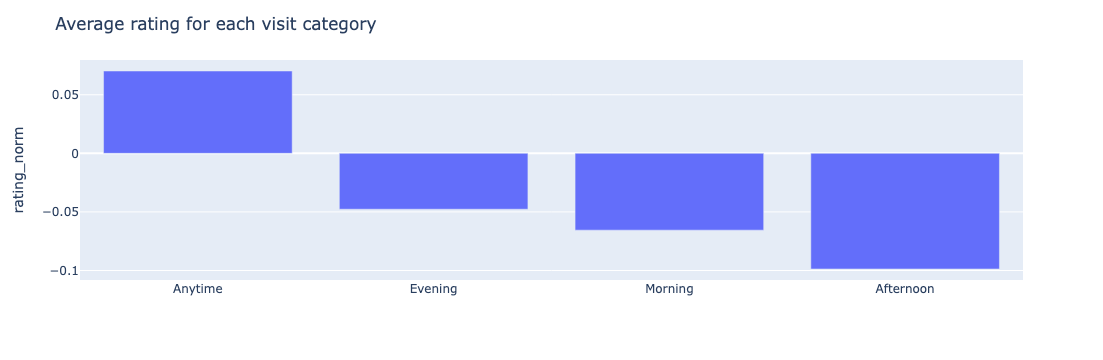

  Source  ddof1  ddof2         F   p-unc       np2
0  visit      4    320  0.441748  0.7784  0.005492


In [679]:
categorical('visit', 'rating_norm')

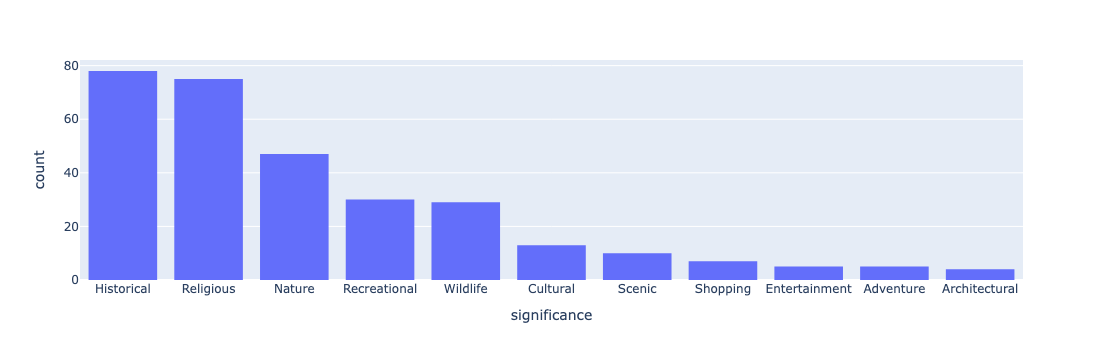

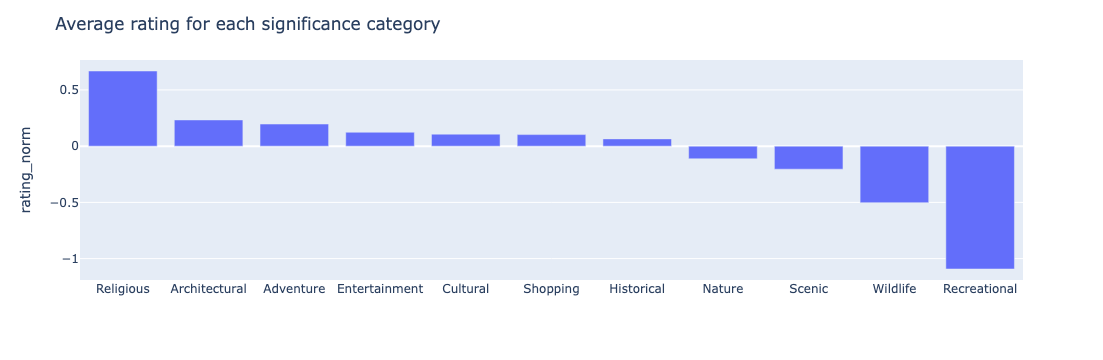

         Source  ddof1  ddof2         F         p-unc       np2
0  significance     24    300  4.714182  3.796962e-11  0.273855


,category,p-value
0,Religious,5.739242e-24
1,Wildlife,3.100008e-04
2,Recreational,9.313066e-03


In [681]:
categorical('significance', 'rating_norm')

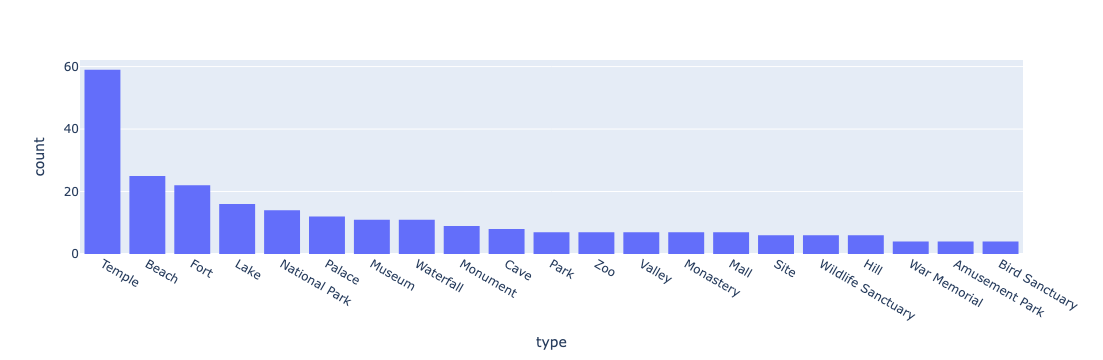

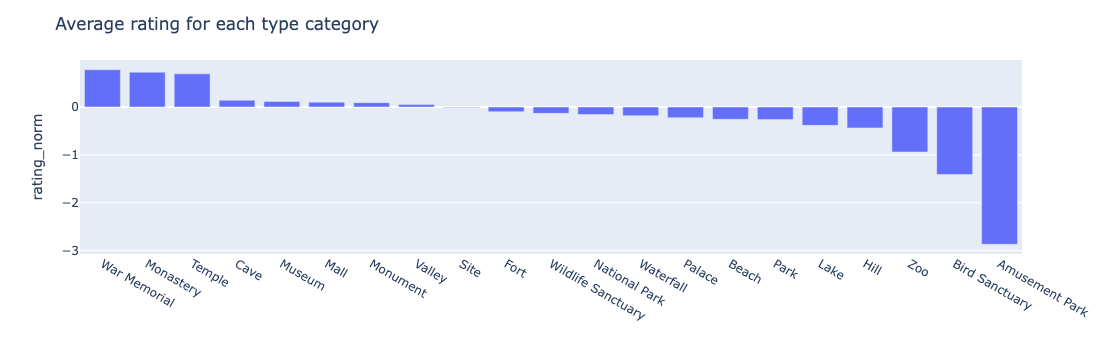

  Source  ddof1  ddof2         F         p-unc       np2
0   type     77    247  2.557954  2.177626e-08  0.443647


,category,p-value
0,War Memorial,3.418494e-02
1,Monastery,2.603358e-04
2,Temple,1.221772e-20
3,Zoo,8.655803e-04


In [683]:
categorical('type', 'rating_norm')

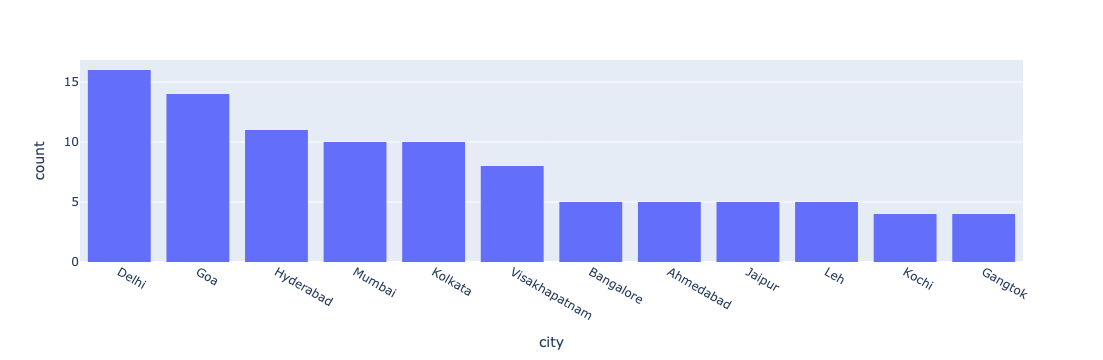

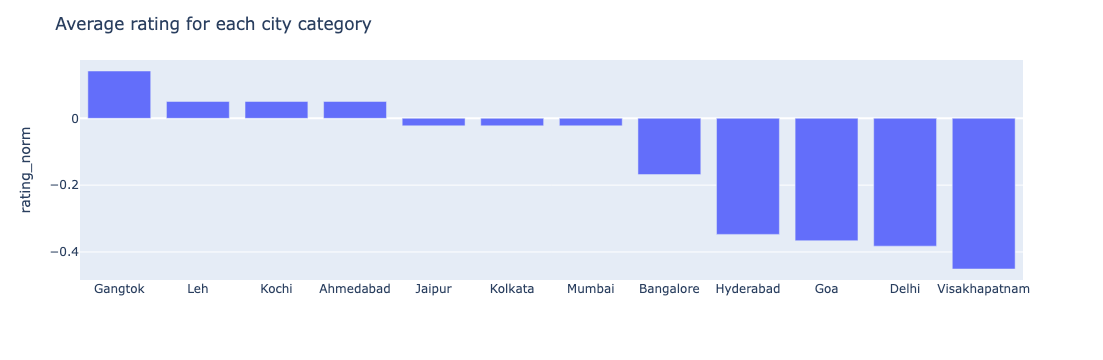

  Source  ddof1  ddof2         F     p-unc       np2
0   city    213    111  0.878711  0.788786  0.627723


,category,p-value
0,Delhi,0.047074


In [685]:
categorical('city', 'rating_norm')

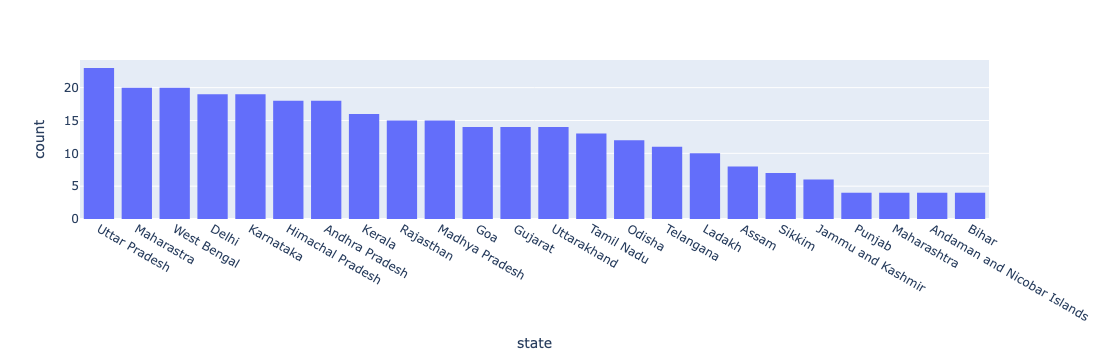

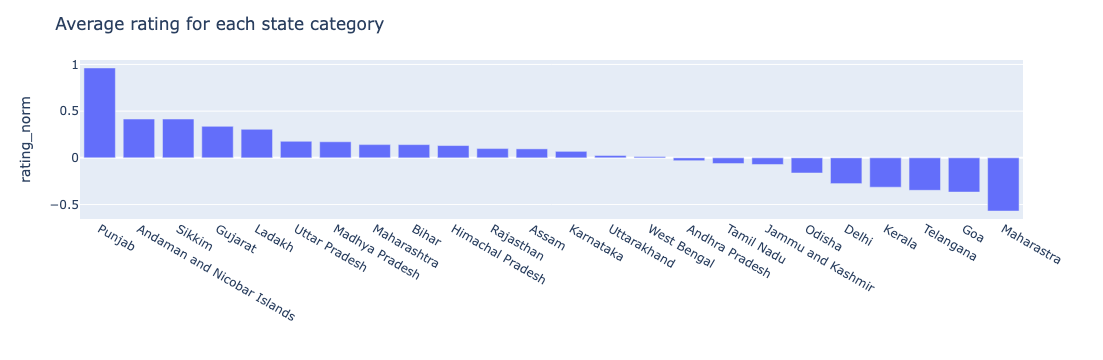

  Source  ddof1  ddof2         F     p-unc       np2
0  state     32    292  0.808365  0.761932  0.081379


,category,p-value
0,Gujarat,0.035801


In [687]:
categorical('state', 'rating_norm')

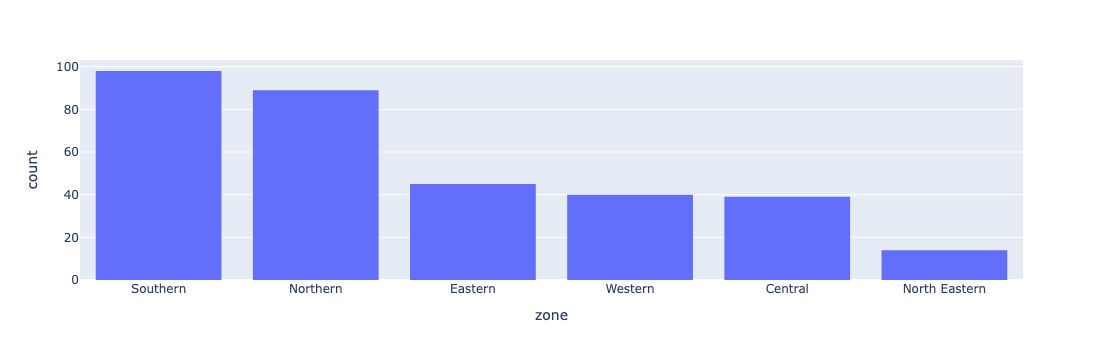

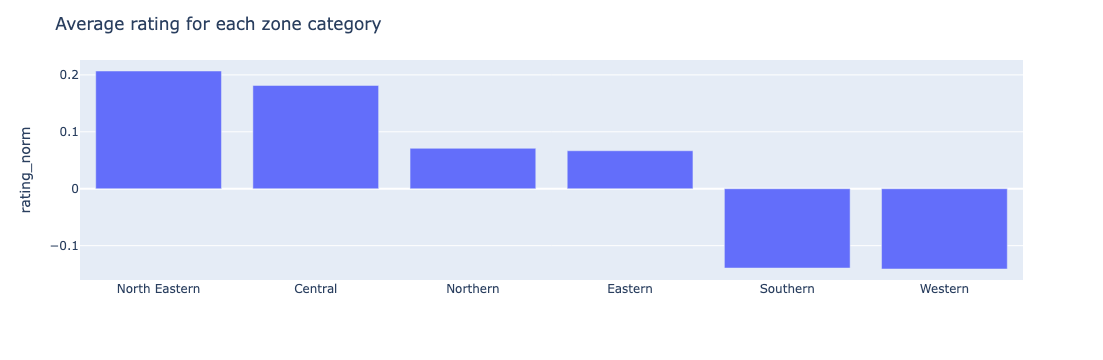

  Source  ddof1  ddof2         F    p-unc       np2
0   zone      5    319  1.043268  0.39215  0.016089


In [689]:
categorical('zone', 'rating_norm')

In [148]:
def find_min_value(function, start, end, step, var_1, var_2):
    """
    Finds the minimum value of a function within a given range.

    Args:
        function: The function to minimize.
        start: The starting point of the range.
        end: The ending point of the range.
        step: The step size for iteration.

    Returns:
        The minimum value of the function within the range.
    """

    x_values = [x for x in range(start, end + 1, step)]
    y_values = [function(x, var_1, var_2) for x in x_values]

    min_value = min(y_values)
    min_index = y_values.index(min_value)
    min_x = x_values[min_index]

    return min_value, min_x

In [220]:
def chisqp(value, var_1, var_2): 
    return sp.stats.chi2_contingency(pd.crosstab(df[var_1].apply(lambda x: 1 if x > value else 0), df[var_2]))[1]

In [204]:
min_value, min_x = find_min_value(chisqp, int(df['year_num'].min()), 1975, 1, 'year_num', 'camera')
print("Minimum value:", min_value)
print("x value at minimum:", min_x)

Minimum value: 0.007118608807640988
x value at minimum: 1970


In [222]:
min_value, min_x = find_min_value(chisqp, 1300, 1500, 1, 'year_num', 'camera')
print("Minimum value:", min_value)
print("x value at minimum:", min_x)

Minimum value: 0.01038452997698236
x value at minimum: 1431


In [224]:
chisqp(4.5, 'rating', 'camera')

1.5008285136017844e-18

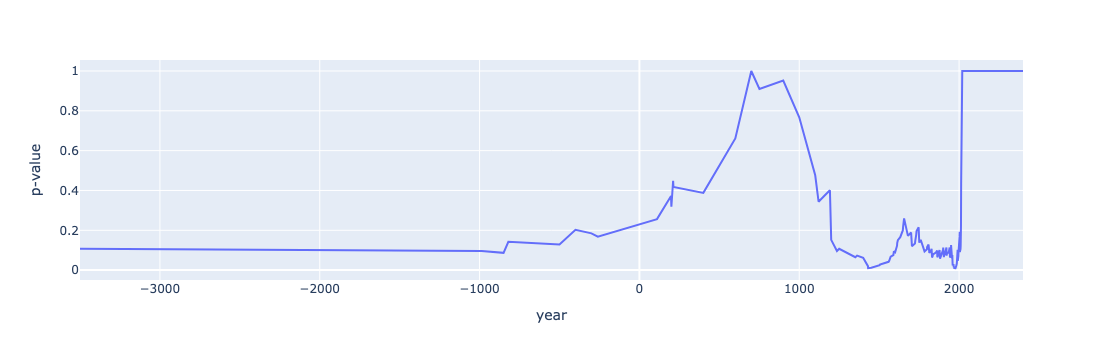

In [226]:

p_lst= []


for year in df['year_num'].dropna():
    p_lst.append(chisqp(year, 'year_num', 'camera'))
    p_df = pd.DataFrame(list(zip(df['year_num'].dropna(), p_lst)), columns = ['year', 'p-value'])
p_df


px.line(p_df.sort_values('year'), x = 'year', y = 'p-value')
    

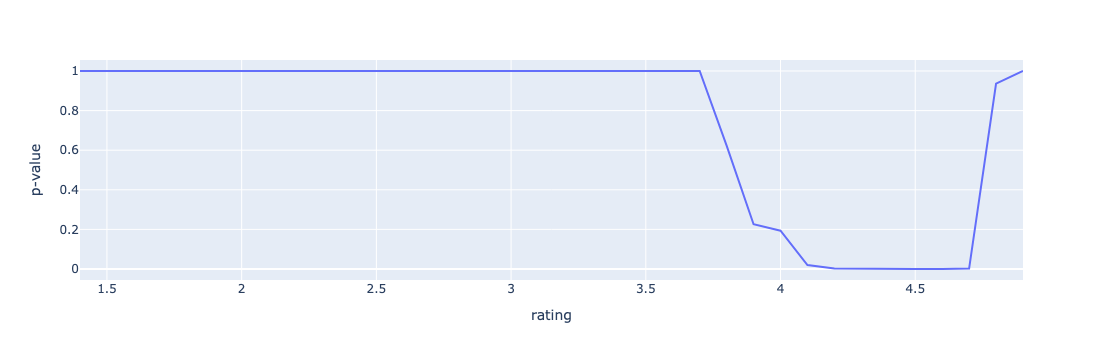

In [228]:

p_lst= []


for rating in df['rating'].dropna():
    p_lst.append(chisqp(rating, 'rating', 'camera'))
    p_df = pd.DataFrame(list(zip(df['rating'].dropna(), p_lst)), columns = ['rating', 'p-value'])
p_df


px.line(p_df.sort_values('rating'), x = 'rating', y = 'p-value')
    